# Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed

# Data

In [2]:
# load your dataset
df_train = pd.read_parquet('./data/cic_iomt_2024_wifi_mqtt_train.parquet')  # load your training data
df_test = pd.read_parquet('./data/cic_iomt_2024_wifi_mqtt_test.parquet')   # load your test data

# randomly select % of the training and test data (for exploration)
df_train_sampled = df_train.sample(frac=0.01, random_state=1984)        # % of train data
df_test_sampled = df_test.sample(frac=0.01, random_state=1984)              # % of test data

# define training and testing features and labels
X_train = df_train_sampled.drop(columns=['label', 'class_label', 'category_label', 'attack_label'])
y_train = df_train_sampled['attack_label']
X_test = df_test_sampled.drop(columns=['label', 'class_label', 'category_label', 'attack_label'])
y_test = df_test_sampled['attack_label']


# PSO

##### This code implements Particle Swarm Optimization (PSO) for feature selection in a classification task using a Random Forest classifier. The idea is to optimize the selection of features from the dataset by treating the selection problem as a swarm optimization problem, where each particle in the swarm represents a potential solution (a subset of features).

In [3]:
# define the fitness function for evaluating feature subsets
def evaluate_feature_selection(particle_position):
    # function selects the features based on the particle's position vector - features with values > 0.5 are selected
    selected_features = np.where(particle_position > 0.5)[0]  # select features based on particle position
    if len(selected_features) == 0:                  # avoid empty feature set
        return 0
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    # create rf model, n_estimators controls rf size, n_jobs controls cores used for single rf
    rf = RandomForestClassifier(n_estimators=20, n_jobs=1, random_state=1984)
    rf.fit(X_train_selected, y_train)                # fit the model
    y_pred = rf.predict(X_test_selected)             # predict attack_label
    
    accuracy = accuracy_score(y_test, y_pred)        # calculate accuracy of prediction - fitness function
    return accuracy                                  # return accuracy as the fitness score

In [4]:
# particle processing function
def process_particle(particle, global_best_position):
    # Evaluate fitness
    fitness = evaluate_feature_selection(particle.position)

    # Update personal best
    if fitness > particle.best_fitness:
        particle.best_fitness = fitness
        particle.best_position = np.copy(particle.position)

    # Update velocity and position
    inertia_weight = 0.5
    cognitive_component = 1.5
    social_component = 1.5

    r1 = np.random.rand(len(particle.position))
    r2 = np.random.rand(len(particle.position))

    particle.velocity = (
        inertia_weight * particle.velocity
        + cognitive_component * r1 * (particle.best_position - particle.position)
        + social_component * r2 * (global_best_position - particle.position)
    )
    particle.position += particle.velocity

    # Ensure position is a valid feature selection (0 or 1)
    particle.position = np.where(particle.position > 0.5, 1.0, 0.0)

    return particle

In [5]:
# Particle class for feature selection
# Each particle in PSO represents a candidate solution for feature selection
class FeatureParticle:
    def __init__(self, n_features):
        self.position = np.random.rand(n_features)                     # random values between 0 and 1 for each feature in dataset
        self.velocity = np.zeros(n_features)                           # velocity of the particle
        self.best_position = np.copy(self.position)                    # feature subset (the best) that this particle has encountered
        self.best_fitness = evaluate_feature_selection(self.position)  # classification accuracy of the best feature

In [6]:
# PSO parameters
num_particles = 10                          # number of particles in the swarm - number of candidate solutions
num_iterations = 20                         # number of iteration the algorithm will run
n_features = X_train.shape[1]               # number of features in dataset (45), each particle will have a postion of lenghth n_features

# create list of particles
particles = []                              # initialize an empty list to hold the particles
for i in range(num_particles):              # based on defined above number of particles
    st = time.time()
    print(f"Particle {i+1}")
    particle = FeatureParticle(n_features)  # create a new particle
    particles.append(particle)              # add the particle to the list
    et = time.time()
    print(f"Time for particle: {et-st}")

Particle 1
Time for particle: 2.065429925918579
Particle 2
Time for particle: 1.9389491081237793
Particle 3
Time for particle: 0.7776849269866943
Particle 4
Time for particle: 1.7864148616790771
Particle 5
Time for particle: 1.8774690628051758
Particle 6
Time for particle: 1.8568332195281982
Particle 7
Time for particle: 0.5640771389007568
Particle 8
Time for particle: 0.8075342178344727
Particle 9
Time for particle: 0.644733190536499
Particle 10
Time for particle: 1.9190058708190918


In [7]:
# Initialize global best
global_best_position = particles[0].best_position
global_best_fitness = particles[0].best_fitness

In [8]:
# PSO main loop for feature selection
for iteration in range(num_iterations):
    iteration_start = time.time()
    print(f"Iteration {iteration + 1}/{num_iterations}")
    # Can change n_jobs to a specific number to limit the number of processes created
    # -1 uses all cores with 1 process per core
    particles = Parallel(n_jobs=-1)(delayed(process_particle)(particle, global_best_position) for particle in particles)

    # Update global best after all particles have been processed
    for particle in particles:
        if particle.best_fitness > global_best_fitness:
            global_best_fitness = particle.best_fitness
            global_best_position = np.copy(particle.best_position)
    iteration_end = time.time()
    print(f"Iteration time: {iteration_end - iteration_start} seconds")

Iteration 1/20
Iteration time: 7.76707911491394 seconds
Iteration 2/20
Iteration time: 6.443400144577026 seconds
Iteration 3/20
Iteration time: 4.79139518737793 seconds
Iteration 4/20
Iteration time: 4.810935020446777 seconds
Iteration 5/20
Iteration time: 3.537644863128662 seconds
Iteration 6/20
Iteration time: 3.604123115539551 seconds
Iteration 7/20
Iteration time: 3.304949998855591 seconds
Iteration 8/20
Iteration time: 3.2449169158935547 seconds
Iteration 9/20
Iteration time: 3.187687873840332 seconds
Iteration 10/20
Iteration time: 3.210667133331299 seconds
Iteration 11/20
Iteration time: 3.2476601600646973 seconds
Iteration 12/20
Iteration time: 3.2287399768829346 seconds
Iteration 13/20
Iteration time: 3.2905187606811523 seconds
Iteration 14/20
Iteration time: 3.3911068439483643 seconds
Iteration 15/20
Iteration time: 3.470735788345337 seconds
Iteration 16/20
Iteration time: 3.2895689010620117 seconds
Iteration 17/20
Iteration time: 3.279311180114746 seconds
Iteration 18/20
Ite

# Results of Random Forest Classifier with Selected Features

In [9]:
# use the best features identified by PSO
selected_features = np.where(global_best_position > 0.5)[0]
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

# train the Random Forest with selected features
rf = RandomForestClassifier(random_state=1984)
rf.fit(X_train_selected, y_train)
y_pred = rf.predict(X_test_selected)

In [10]:
# print the classification report
report_selected = classification_report(y_test, y_pred)
print(report_selected)

# print the number of selected features
print(f"Number of selected features: {len(selected_features)}")

# calculate accuracy
accuracy_selected = accuracy_score(y_test, y_pred)

# print accuracy with 5 decimal places
print(f"Accuracy: {accuracy_selected:.5f}")

                    precision    recall  f1-score   support

      ARP_spoofing       0.79      0.65      0.71        17
            Benign       0.94      0.99      0.97       339
         DDoS_ICMP       1.00      1.00      1.00      3456
          DDoS_SYN       1.00      1.00      1.00      1792
          DDoS_TCP       1.00      1.00      1.00      1849
          DDoS_UDP       1.00      1.00      1.00      3536
DDoS_connect_flood       1.00      1.00      1.00       408
DDoS_publish_flood       1.00      0.98      0.99        87
          DoS_ICMP       1.00      1.00      1.00      1047
           DoS_SYN       1.00      1.00      1.00      1007
           DoS_TCP       1.00      1.00      1.00       852
           DoS_UDP       1.00      1.00      1.00      1350
 DoS_connect_flood       1.00      1.00      1.00        30
 DoS_publish_flood       0.98      1.00      0.99        82
    Malformed_date       0.91      0.62      0.74        16
           OS_scan       0.76      0.69

/Users/alexcoward/.local/share/virtualenvs/pso-NFvADFv5/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexcoward/.local/share/virtualenvs/pso-NFvADFv5/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexcoward/.local/share/virtualenvs/pso-NFvADFv5/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

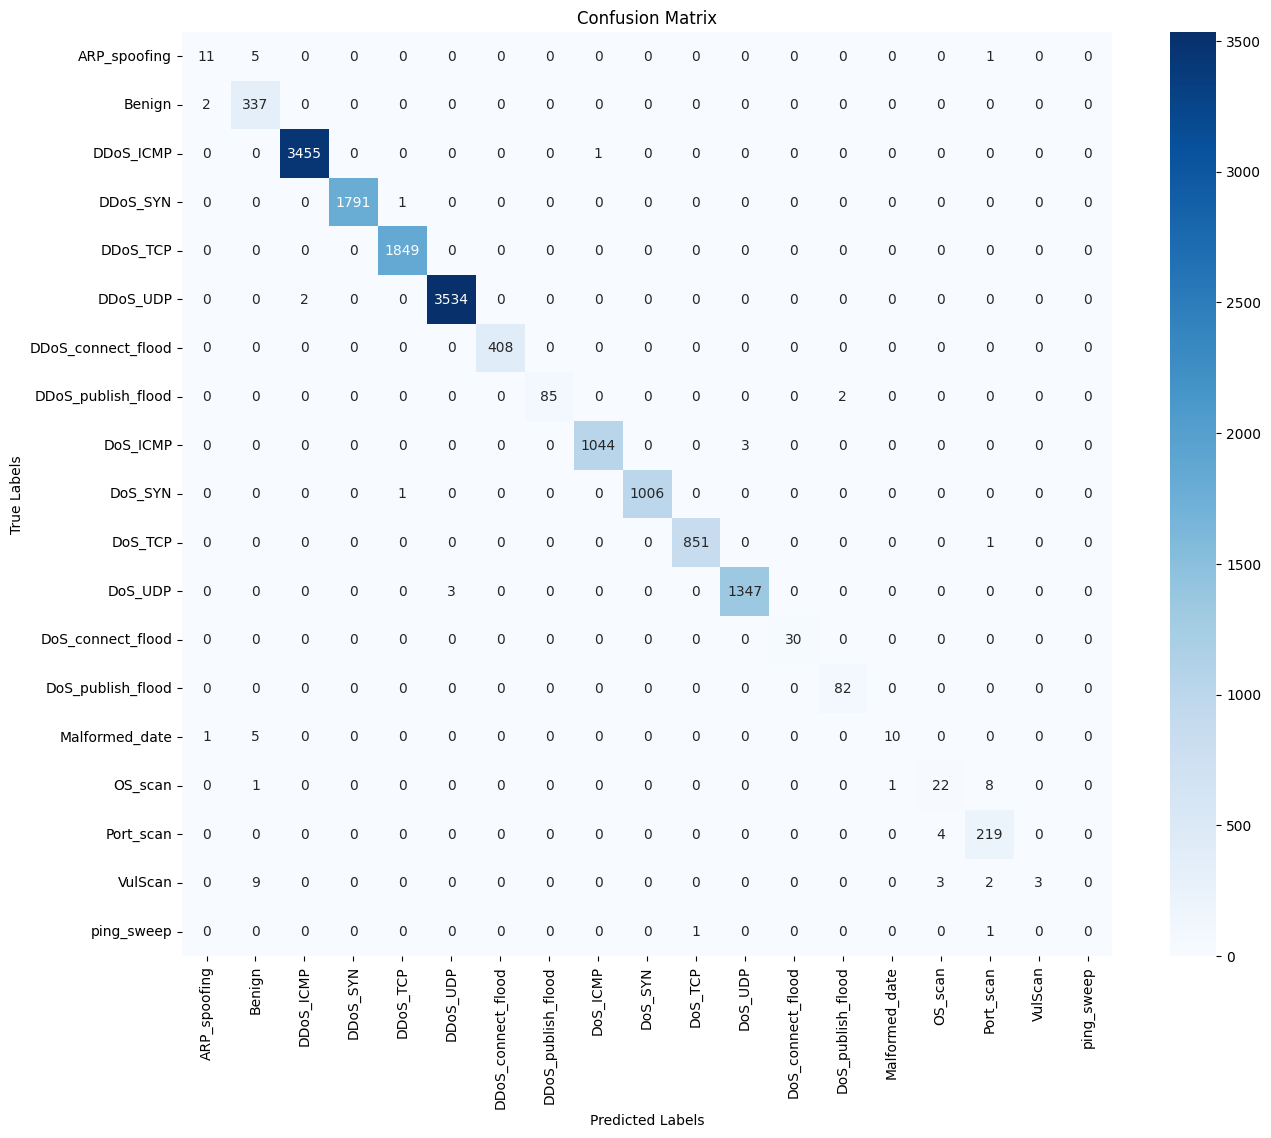

In [11]:
# generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# visualize the confusion matrix using seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Results of Random Forest Classifier with All Features

In [12]:
# use all features identified by PSO to train a Random Forest
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=1984)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [13]:
# print the classification report
report_full = classification_report(y_test, y_pred)
print(report_full)

# calculate accuracy
accuracy_full = accuracy_score(y_test, y_pred)

# print accuracy with 5 decimal places
print(f"Accuracy: {accuracy_full:.5f}")

                    precision    recall  f1-score   support

      ARP_spoofing       0.60      0.71      0.65        17
            Benign       0.92      0.96      0.94       339
         DDoS_ICMP       1.00      1.00      1.00      3456
          DDoS_SYN       1.00      1.00      1.00      1792
          DDoS_TCP       1.00      1.00      1.00      1849
          DDoS_UDP       1.00      1.00      1.00      3536
DDoS_connect_flood       1.00      1.00      1.00       408
DDoS_publish_flood       1.00      0.11      0.21        87
          DoS_ICMP       1.00      1.00      1.00      1047
           DoS_SYN       1.00      1.00      1.00      1007
           DoS_TCP       1.00      1.00      1.00       852
           DoS_UDP       0.99      1.00      0.99      1350
 DoS_connect_flood       1.00      1.00      1.00        30
 DoS_publish_flood       0.51      1.00      0.68        82
    Malformed_date       1.00      0.75      0.86        16
           OS_scan       0.70      0.50

/Users/alexcoward/.local/share/virtualenvs/pso-NFvADFv5/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexcoward/.local/share/virtualenvs/pso-NFvADFv5/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexcoward/.local/share/virtualenvs/pso-NFvADFv5/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

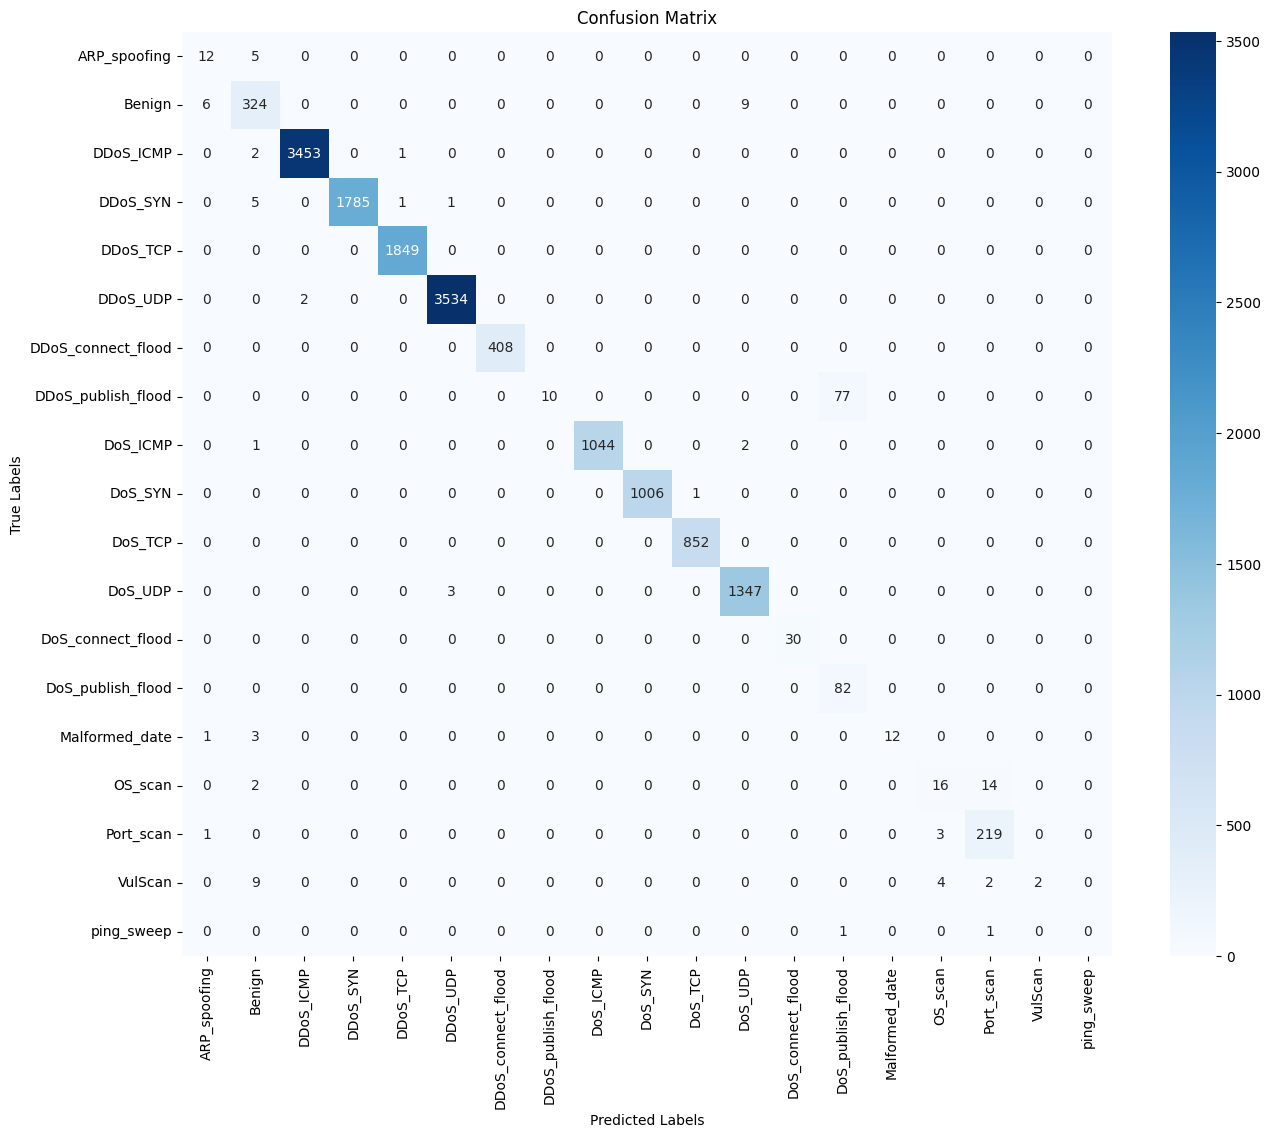

In [14]:
# generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# visualize the confusion matrix using seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
print(accuracy_selected - accuracy_full)

0.00613306901251387


# This notebook demonstrates how Particle Swarm Optimization (PSO) can be applied to reduce the dimensionality of a dataset before training a machine learning model. By selecting the most relevant features, PSO helps to optimize the model's performance while potentially reducing computational costs and increasing the speed of an Intrusion Detection System (IDS). Feature reduction through PSO allows the model to focus on the most informative data, which can lead to faster training times and more efficient resource usage.